# Visualizations

This script is for creating a word cloud out of the hashtags used from the gathering of Twitter data as well as other visualzizations. It's in a separate notebook because the other notebook was busy gathering data from Twitter. This is exactly why I chose a database to collect Tweets since it supports concurrency of read/write. This allows me to experiment with the data collected without stopping collection. There are other ways to go about this, but I wanted to learn the psycopg2 Python module and actually create a database. The code is not the prettiest because the timeframe was short, but it's functional and I learned along the way. 

### Import Modules

In [27]:
import pprint
import psycopg2
import time
from wordcloud import WordCloud
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import Counter
import jsonconfig as jsc

### Database Connection Establishment

In [28]:
# A database needs to be created already and user/password should be configured as well

# Import credentials from config file
psql_cred = jsc.json_config('config/psql_config.json')
dbname = psql_cred['psql']['dbname']
host = psql_cred['psql']['host']
port = psql_cred['psql']['port']
user = psql_cred['psql']['user']
password = psql_cred['psql']['password']

# Set up database connection
psql_connection = psycopg2.connect(dbname=dbname,
                   host= host,
                   port=port, 
                   user=user, 
                   password=password)


# Needed for connection
cursor = psql_connection.cursor()

# Print PostgreSQL Connection properties
print (psql_connection.get_dsn_parameters(),"\n")

{'user': 'cdog', 'dbname': 'twitter', 'host': '127.0.0.1', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



### Execute the query to fetch all hashtags

In [29]:
cursor.execute("SELECT t.hashtag FROM public.twitter t;")

Fetch a entry to make sure it worked

In [30]:
cursor.fetchone()

(['ElCacas '],)

Now to Loop through the database to grab all the hashtags

In [31]:
# Execute the query from the twitter_t database
cursor.execute("SELECT t.hashtag FROM public.twitter t;")


# Keyword that was collected on Twitter that I want to filter out of the word cloud
keyword_list = []

# Add hashtags to this
string_list = ""
hashtag_list = []

# Loop through the query
for i in cursor:
    
    # Only pass if the length of list is more than 0
    if len(i[0]) > 0:
        
        # if the hashtag list is 1, no loop is needed
        if len(i[0]) == 1:
            
            # Create a standard of text to compare against
            a = str(i[0][0]).lower().replace(" ","")
            
            # Hardcode to filter out the cycling hashtags
            if a == "cyclinglife" or a == "roadcycling" or a == "eritelcyclingclub" or a == "cycling" or a == "abiyahmed":
                continue
            else:    
                if a in keyword_list:
                    continue
                else:
                    string_list += " " + a
                    hashtag_list.append(a)
                
        # Loops through the list of each hashtag for that tweet
        for j in i[0]:

            # Create a standard of text to compare against
            j = j.lower().replace(" ","")

            # Had trouble with this guys name being filtered for some reason
            if j in keyword_list:
                continue
            else:
                string_list += " " + str(j)
                hashtag_list.append(j)



In [32]:
count_hashtags = Counter(hashtag_list)
# count_hashtags

## Create a Word Cloud

This cell creates a word cloud out of my giant string of hashtags. I originally tried a list, but the word cloud module in Python prefers a text file or string. Since I collected on all languages that had the keywords present, there are different hashtags in languages that I'm unsure how to handle at the moment. They are represented in [] format similar to when your phone/computer doesn't recognize emojis. 

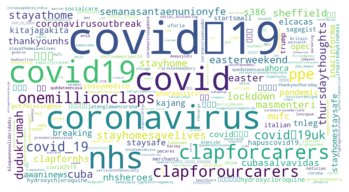

In [33]:
# Help was sought from the documentation of the wordcloud Python Module examples.
wordcloud = WordCloud(background_color="white",width=1500, height=800,max_font_size=200,collocations=False, random_state=1).generate(string_list)

# Save to file
wordcloud.to_file("wordcloud.png")

# Plot the figure
plt.figure()

# Show the figure in the color scheme
plt.imshow(wordcloud, interpolation="bilinear")

# Turn axis off
plt.axis("off")

# Show word cloud
plt.show()

## More Visualizations

It's hard to know when your efforts are over in this lab, but I felt like I could do more since I was too constrained on time to investigate each individual's tweets. I also learned that a max of 3,200 tweets could be returned for a single user. This may cause problems with people who tweet a lot. For reference the average status count was 22,699 at one point (Over 2,700 Tweets) during the collection.

Select Tweet Date and count how many tweets were collected each day. 

In [23]:
# Execute the query from the twitter_t database
cursor.execute("SELECT t.screen_name, t.time FROM public.twitter t;")


# Blank dictionary creation
date_dict = {}

# Loop through the collected rows
for row in cursor:
    
    # Variable collection
    month = time.localtime(row[1]).tm_mon
    day = time.localtime(row[1]).tm_mday
    year = time.localtime(row[1]).tm_year

    # Value for dictionary key (Raw Lists are unhashable)
    date = str([month, day, year])

    # Check to see if the entry exists in the dictionary
    if date in date_dict:
        date_dict[date] += 1

    # If not, create the key
    else:
        date_dict[date] = 1

        
date_dict

{'[4, 9, 2020]': 2448}

Convert the dictionary to a lists of x,y to plot.

In [16]:
x = []
y = []

# Loop through the dictionary to create new lists
for g in date_dict:
    x.append(g)
    y.append(date_dict[g])
    
print(x,"\n",y)

['[4, 9, 2020]'] 
 [1721]


Reorder List so the days are sequential. .sort() did not seem to work with a string of a list. 

In [24]:
# The order you want 
myorder = [0,3,1,2,4]


x = [x[i] for i in myorder]
y = [y[i] for i in myorder]

print(x,y)

IndexError: list index out of range

Plot the 

In [ ]:
x = x
y = y

# Figure size
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='red')

# Rotation of tick marks on x-axis
plt.xticks(rotation = 60)

# X-lim for x-axis
plt.xlim(-1,5)

# Plot with a specific color pallete
fig = plt.bar(x, y, color=sns.color_palette("Blues",4))

# Create a legend
plt.legend(fig, x, loc = "upper left", title = "Dates")

# Show plot
plt.show()

### Number of Unique Users

This could have been done easier in PgAdmin, but I wanted to see if there was a good way to do it with Psycopg2.

In [18]:
# Execute the query from the twitter_t database
cursor.execute("SELECT DISTINCT(t.screen_name) FROM public.twitter_t t;")
unique_user = []

for row in cursor:
    unique_user.append(row[0])
    
print("There are",len(unique_user),"unique users tweeting about these keywords in the past several days")

UndefinedTable: relation "public.twitter_t" does not exist
LINE 1: SELECT DISTINCT(t.screen_name) FROM public.twitter_t t;
                                            ^
